In this body of work, i will try to categorize about 400k non-merged pull requests.
First, we need to import the libraries.

In [1]:
from transformers import AutoTokenizer, AutoModelForMaskedLM, BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix
from sklearn.preprocessing import LabelEncoder

import re
import ast
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns

import pytorch_lightning as pl
from torchmetrics.functional import accuracy, f1_score, auroc
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.metrics import accuracy_score


from tqdm.auto import tqdm


In [3]:
#reading the data
df = pd.read_csv('/Users/amirrshams/Library/CloudStorage/OneDrive-UniversityofWaterloo/Thesis/Dataset/Dataset/Non_Merged/Sample/Sample_2_500_manual.csv')

In [4]:
df.head()

,Unnamed: 0,repo_id,status,pr_id,pullreq_id,api_url,url,pr_url,pr_api_url,author_id,author_desc_body,closer_id,comments_counts,comments,commit_counts,code_changes_counts,created_at,closed_at,author_country,closer_country,author_continent,same_country,author_eth,closer_eth,same_eth,prs_white,prs_api,prs_black,prs_hispanic,pri_white,pri_black,pri_api,pri_hispanic,prs_eth_8,prs_eth_7,prs_eth_9,prs_eth_diff,prs_eth_diff_2,manual_analysis,Notes,Keyword
0,42465,634,not-merged,1709840,8432,https://api.github.com/repos/symfony/symfony,https://github.com/symfony/symfony,https://github.com/symfony/symfony/pull/8432,https://api.github.com/repos/symfony/symfony/p...,entering,| Q | A |\n| --- | --- |\n| Bug fix? | no |\n|...,NaN,3,['@entering why did you add the original tab?\...,3,1,2013-07-07T10:21:21Z,2013-07-07T15:48:42Z,germany,france,Europe,0,Unknown,White,0,0.583243,0.016764,0.001686,0.388724,0.958822,0.015781,0.005251,0.019089,Unknown,Unknown,Unknown,Unknown,Unknown,No reason,"no keyword here, by looking at the history it ...",NaN
1,741644,41674,not-merged,364962,8,https://api.github.com/repos/Barbatos/ioq3-for...,https://github.com/Barbatos/ioq3-for-UrbanTerr...,https://github.com/Barbatos/ioq3-for-UrbanTerr...,https://api.github.com/repos/Barbatos/ioq3-for...,ghostmod,"Additions Private bigText control, Additions t...",NaN,1,['Thank you for the pull request. We would lik...,7,5,2012-09-10T11:29:56Z,2012-10-14T14:11:22Z,united states,united states,North America,1,Unknown,White,0,0.891456,0.016254,0.036790,0.055501,0.998299,0.000572,0.000146,0.000951,Unknown,White,Unknown,White,White,Unnecessary,NaN,"""Decided not to integrate"""
2,1937105,7704341,not-merged,8714711,3120,https://api.github.com/repos/neovim/neovim,https://github.com/neovim/neovim,https://github.com/neovim/neovim/pull/3120,https://api.github.com/repos/neovim/neovim/pul...,Yamakaky,This PR is meant to bring XDG support to neovi...,NaN,35,['The [tmp] commit will be squashed before mer...,15,2,2015-07-31T15:03:00Z,2015-08-19T18:07:40Z,france,\N,Europe,0,White,White,1,0.884086,0.059685,0.035040,0.021189,0.929338,0.063018,0.001640,0.003318,White,White,Unknown,White,White,Replaced,NaN,NaN
3,1426992,2855187,not-merged,4176486,7,https://api.github.com/repos/boostorg/interpro...,https://github.com/boostorg/interprocess,https://github.com/boostorg/interprocess/pull/7,https://api.github.com/repos/boostorg/interpro...,ismirlian,Having a variable named hz conflicts with the ...,NaN,1,"['Renamed the variable to ""ticks_per_second"" i...",1,1,2014-07-16T21:33:07Z,2014-07-30T14:42:33Z,\N,\N,\N,0,Unknown,White,0,0.893650,0.018823,0.030366,0.055919,0.950273,0.000591,0.001511,0.047625,Unknown,White,Unknown,White,White,Merge Conflict,NaN,NaN
4,179674,1958,not-merged,5391718,3111,https://api.github.com/repos/infinispan/infini...,https://github.com/infinispan/infinispan,https://github.com/infinispan/infinispan/pull/...,https://api.github.com/repos/infinispan/infini...,galderz,https://issues.jboss.org/browse/ISPN-5029\n,NaN,3,['```\n[17:57:54][ERROR] /.../persistence/jdbc...,1,19,2014-11-27T13:56:53Z,2014-12-09T13:49:44Z,switzerland,italy,Europe,0,Unknown,Unknown,0,0.417943,0.020143,0.017398,0.543187,0.931777,0.049968,0.011553,0.004525,Unknown,Unknown,Unknown,Unknown,Unknown,Successful,NaN,NaN


In [4]:
#drop some of the columns
df = df.drop(['api_url', ' url', 'pr_url', 'pr_api_url', 'author_id', 'author_desc_body', 'closer_id','commit_counts', 'code_changes_counts', 'created_at', 'closed_at', 'author_country', 'author_continent', 'same_country', 'author_eth', 'closer_eth','closer_country', 'same_eth', 'prs_white', 'prs_black', 'prs_api', 'prs_hispanic', 'pri_white', 'pri_black', 'pri_api', 'pri_hispanic', 'prs_eth_7', 'prs_eth_8', 'prs_eth_9', 'prs_eth_diff', 'prs_eth_diff_2', 'Keyword', 'Notes'], axis=1)

In [5]:
df.head()

,Unnamed: 0,repo_id,status,pr_id,pullreq_id,comments_counts,comments,manual_analysis
0,42465,634,not-merged,1709840,8432,3,['@entering why did you add the original tab?\...,No reason
1,741644,41674,not-merged,364962,8,1,['Thank you for the pull request. We would lik...,Unnecessary
2,1937105,7704341,not-merged,8714711,3120,35,['The [tmp] commit will be squashed before mer...,Replaced
3,1426992,2855187,not-merged,4176486,7,1,"['Renamed the variable to ""ticks_per_second"" i...",Merge Conflict
4,179674,1958,not-merged,5391718,3111,3,['```\n[17:57:54][ERROR] /.../persistence/jdbc...,Successful


In [6]:
df['manual_analysis'].unique()

array(['No reason', 'Unnecessary', 'Replaced', 'Merge Conflict',
       'Successful', 'Stale', 'Resolved', 'Quality', 'Duplicate',
       'Chaotic'], dtype=object)

<Axes: xlabel='manual_analysis'>

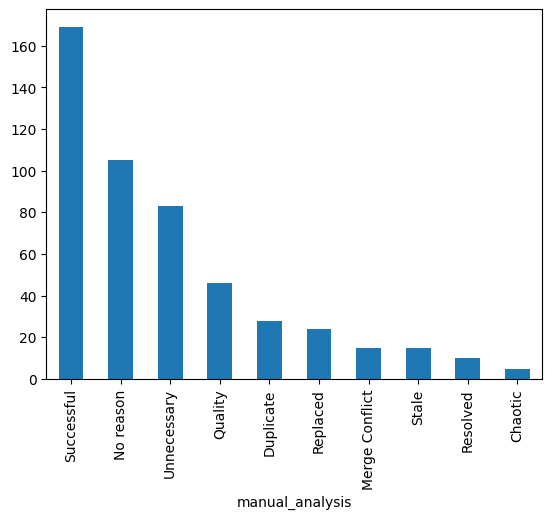

In [7]:
labels = df['manual_analysis']
labels.value_counts().plot(kind='bar')

### cleaning the comments texts

In [8]:
def text_preprocess(text):
    text = re.sub(r'@[A-Za-z0-9]+','',text) #remove @mentions
    text = re.sub(r'#','',text) #remove # symbol
    text = re.sub(r'https?:\/\/\S+','',text) #remove the hyper link
    text = re.sub(r'\n','',text) #remove \n
    text = re.sub(r'www\S+', '', text) #remove www
    return text
df['comments'] = df['comments'].apply(lambda x: ast.literal_eval(x))
df['comments'] = df['comments'].apply(lambda x: [text_preprocess(t) for t in x])
df['comments'] = df['comments'].apply(lambda x: ' '.join(x))
df['comments'] = df['comments'].apply(lambda x: x if len(x) > 0 else '[No comments]')

In [9]:
sample_row = df.iloc[2]
sample_comment = sample_row.comments
sample_lable = sample_row.manual_analysis
print(sample_comment)
print(len(sample_comment))
print(sample_lable)

The [tmp] commit will be squashed before merge. I think nvim should still fallback on ~/.nvim/nvimrc and then ~/.nvimrc. How does this handle that? Let's just get everyone up to speed on what `XDG_RUNTIME_DIR` is and what the requirements on it are:- Used for non-essential, user-specific data files such as sockets, named pipes, etc.- Defaults to nothing, warnings should be issued if not set or equivalents provided.- Must be owned by the user.- Access mode must be `0700`.- Filesystem fully featured by standards of OS.- Must be on the local filesystem.- May be subject to periodic cleanup.- Modified every 6 hours or set sticky bit if persistence is desired.- Can only exist for the duration of the user's login.- Shouldn't store large files as it may be mounted as a tmpfs.Generally you don't create this directory, something like logind would.  However if you do not use logind, you have to create it with the requirements listed above.  Why do you think so? NeoVim is still not stable so it do

In [10]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df.manual_analysis.values)

## Creating the model

In [11]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
tokens = tokenizer.batch_encode_plus(
    df['comments'],
    max_length = 512,
    padding = 'max_length',
    return_attention_mask = True,
    return_token_type_ids = False,
    truncation=True,
    return_tensors = 'pt'
)

input_ids = tokens['input_ids']
attention_mask = tokens['attention_mask']




In [12]:
tokens['input_ids'].shape, tokens['attention_mask'].shape

(torch.Size([500, 512]), torch.Size([500, 512]))

(0.0, 1000.0)

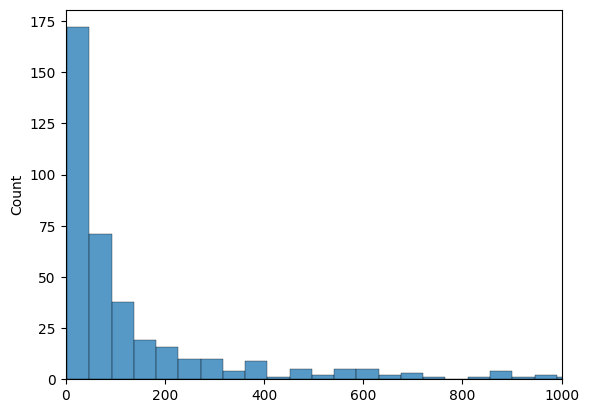

In [13]:
#checking the number of tokens:
token_counts = []
for _, row in train_df.iterrows():
    token_count = len(tokenizer.encode(
        row['comments'],
        max_length = 20000,
        truncation = True,
    ))
    token_counts.append(token_count)

sns.histplot(token_counts)
plt.xlim([0, 1000])

In [63]:
# #reshape input_ids to one dimension (20000)
# input_ids = input_ids.flatten()
# input_ids.shape

torch.Size([10000000])

In [67]:
# tokenizer.convert_ids_to_tokens(tokens["input_ids"].flatten())[20:40]

['touched',
 'that',
 'file',
 'to',
 'remove',
 'the',
 'else',
 ',',
 'if',
 'don',
 "'",
 't',
 'want',
 'it',
 ',',
 'i',
 'reverted',
 'all',
 'changes',
 'to']

In [14]:
le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['manual_analysis'])

In [15]:
#having the tokenization in a pytorch Dataset
class PRCommentDataset(Dataset):
    def __init__(self, df, tokenizer, max_length: 512):
        self.df = df
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.comments)

    def __getitem__(self, index):
        comment = self.df.loc[index, 'comments']
        labels = self.df.loc[index, 'label_encoded']
        encoding = self.tokenizer.encode_plus(
            comment,
            max_length = self.max_length,
            padding = 'max_length',
            truncation = True,
            return_attention_mask = True,
            return_token_type_ids = False,
            return_tensors = 'pt'
        )

        return dict(
            comment_text = comment,
            input_ids = encoding['input_ids'].flatten(),
            attention_mask = encoding['attention_mask'].flatten(),
            labels=torch.tensor(labels, dtype = torch.long)
        )


In [16]:
train_dataset = PRCommentDataset(train_df, tokenizer, max_length=512)

sample_item = train_dataset[350]
sample_item.keys()

KeyError: 350

In [135]:
sample_item['comment_text']


'Cutting at ~ is the most sensible way of dealing with /NICKs containing ~. Simply rejecting the nick is far too sane and expected. The correct behavior of /NICK foo~bar is _clearly_ to change the nickname to "foo", not to indicate that the nickname is erroneous.'

In [139]:
sample_item['input_ids'].shape

torch.Size([134144])

In [140]:
model = BertModel.from_pretrained('bert-base-uncased')
sample_batch = next(iter(DataLoader(train_dataset, batch_size=8, num_workers=2)))
sample_batch["input_ids"].shape, sample_batch["attention_mask"].shape

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Users/amirrshams/miniforge3/envs/m1_gpu/lib/python3.9/multiprocessing/sp

KeyboardInterrupt: 

In [23]:
class PRCommentDataModule(pl.LightningDataModule):
    def __init__(self, train_df, test_df, tokenizer, batch_size=32, max_length=512):
        super().__init__()
        self.train_df = train_df
        self.test_df = test_df
        self.tokenizer = tokenizer
        self.batch_size = batch_size
        self.max_length = max_length
    
    def setup(self, stage=None):
        self.train_dataset = PRCommentDataset(self.train_df, self.tokenizer, self.max_length)
        self.test_dataset = PRCommentDataset(self.test_df, self.tokenizer, self.max_length)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle = True, num_workers=4)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, num_workers=4)
    
    def val_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, num_workers=4)
    

In [18]:
from typing import Any, Optional


from pytorch_lightning.utilities.types import STEP_OUTPUT


class PRCommentClassifier(pl.LightningModule):
    def __init__(self, n_classes = 11):
        super().__init__()
        self.model = BertModel.from_pretrained('bert-base-uncased', num_labels = n_classes)
        self.n_classes = n_classes
    
    def forward(self, input_ids, attention_mask, labels=None):
        output = self.model(input_ids, attention_mask, labels=labels)
        return output.loss, output.logits
    def training_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        loss, logits = self(input_ids, attention_mask, labels)
        acc = accuracy_score(labels.cpu(), torch.argmax(logits.cpu(), dim=1))
        self.log('train_loss', loss, prog_bar=True)
        self.log('train_acc', acc, prog_bar=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        loss, logits = self(input_ids, attention_mask, labels)
        acc = accuracy_score(labels.cpu(), torch.argmax(logits.cpu(), dim=1))
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)
        return loss
    
    def test_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        loss, logits = self(input_ids, attention_mask, labels)
        acc = accuracy_score(labels.cpu(), torch.argmax(logits.cpu(), dim=1))
        self.log('test_loss', loss, prog_bar=True)
        self.log('test_acc', acc, prog_bar=True)
        return loss
    
    def configure_optimizers(self):
        return AdamW(self.parameters(), lr=2e-5)



In [24]:
data_module = PRCommentDataModule(train_df, test_df, tokenizer)
model = PRCommentClassifier()

trainer = pl.Trainer(max_epochs=10)

trainer.fit(model, data_module)

trainer.test()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Miss

Sanity Checking: 0it [00:00, ?it/s]

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Users/amirrshams/miniforge3/envs/m1_gpu/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/Users/amirrshams/miniforge3/envs/m1_gpu/lib/python3.9/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'PRCommentDataset' on <module '__main__' (built-in)>
/Users/amirrshams/miniforge3/envs/m1_gpu/lib/python3.9/site-packages/pytorch_lightning/trainer/call.py:54: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")
/Users/amirrshams/miniforge3/envs/m1_gpu/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:148: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pa

ValueError: `.test(ckpt_path="best")` is set but `ModelCheckpoint` is not configured to save the best model.

In [ ]:
torch.save(model.state_dict(), 'bert_model.pth')
